In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras

In [28]:
df = pd.read_csv('data.csv')
df.head()
len(df)

50560

Start preprocessing data.


In [29]:
#create column 'future mkvalt' that holds the market value of the next year
condition1 = df['tic'].shift(-1) == df['tic']
condition2 = df['fyear'].shift(-1) == df['fyear'] + 1
df['future_mkvalt'] = np.where(condition1 & condition2, df['mkvalt'].shift(-1), np.nan)

#drop nulls
df = df.dropna(subset=['mkvalt', 'future_mkvalt'], how='all')

#percent change is the percent change in market value from one year to the next
df['percent_change'] = (df['future_mkvalt']-df['mkvalt'])/df['mkvalt']

#if percent change is greater than 10%, classify as undervalued
df['undervalued'] = (df['percent_change'] > .1)

In [30]:
#fill null expenses with 0
df['xrd'] = df['xad'].fillna(0)
df['xad'] = df['xad'].fillna(0)
df['xsga'] = df['xsga'].fillna(0)
df['xint'] = df['xsga'].fillna(0)

#combine all expenses columns into one column
expenses_list = ['xrd', 'xad', 'xsga', 'xint', 'nopio', 'cogs']
df['expenses'] = df[expenses_list].sum(axis=1)

df = df.drop(columns=expenses_list)

#delete duplicate rows due to formatting
condition = df['indfmt'] != "FS"
df = df[condition]


#drop unneccessary columns
df = df.drop(columns=['indfmt', 'consol', 'popsrc', 'datafmt', 'curcd', 'gvkey', 'costat', 'dlcch'])

#remove rows with null values
condition = df.isnull().sum(axis=1) < 1
df = df[condition]


In [31]:
df.isnull().sum()

tic               0
fyear             0
act               0
ap                0
at                0
ceq               0
che               0
dlc               0
dltt              0
dp                0
dvc               0
ib                0
intan             0
invt              0
ivao              0
lct               0
lt                0
ppent             0
rect              0
sale              0
spi               0
txp               0
txt               0
xido              0
mkvalt            0
future_mkvalt     0
percent_change    0
undervalued       0
expenses          0
dtype: int64

In [32]:
len(df)

18538

Text(0.5, 0, 'Percent Increase in market value over 1 year period')

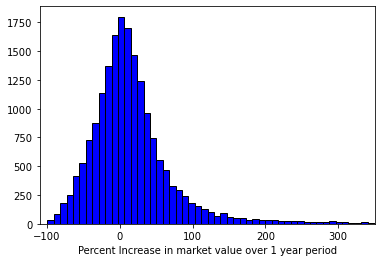

In [33]:

binwidth=0.1
    
# Set up the plot
plot = plt.subplot(1, 1, 1 )
    
# Draw the plot
plot.hist(df['percent_change']*100, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
plt.xlim(-110, 350)
plot.set_xlabel('Percent Increase in market value over 1 year period', size = 10)


In [34]:
#remove outliers
condition1 = df['percent_change'] < 1
df = df[condition1]

Text(0.5, 0, 'Percent Increase in market value over 1 year period')

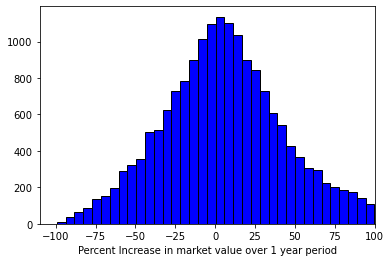

In [35]:
#replot
binwidth=5
    
# Set up the plot
plot = plt.subplot(1, 1, 1 )
plot.hist(df['percent_change']*100, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
#Title and labels
plt.xlim(-110, 100)
plot.set_xlabel('Percent Increase in market value over 1 year period', size = 10)

In [36]:
print(df['percent_change'].mean())
print(df['percent_change'].median())

0.047240676428863
0.03878880889347437


In [37]:
X = df.drop(columns=['tic', 'fyear', 'future_mkvalt', 'percent_change', 'undervalued'])
y = df['undervalued']
y.value_counts()

False    9801
True     7345
Name: undervalued, dtype: int64

In [38]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

X_train = X.iloc[3800:]
X_test = X.iloc[:3800]
y_train = y.iloc[3800:]
y_test = y.iloc[:3800]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

X_train.head()
len(X_train)

13716

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
rf_model = RandomForestClassifier()

params = [{'n_estimators': [100, 200, 400, 800],
        'max_depth': [5, 10, 20, 40, 80],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
          }]

gs = GridSearchCV(rf_model,
                      param_grid=params,
                      scoring='precision',
                      cv=3, verbose=2, return_train_score=False)
gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   6.2s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   6.6s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   6.5s
[CV] END max_depth=5, min_samples_lea

[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=800; total time=  12.6s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=800; total time=  12.4s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=800; total time=  12.4s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   3.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   3.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   3.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time= 

[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  10.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  10.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  10.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  20.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  20.9s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  20.8s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   2.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=12, n_estimators=200;

[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   7.2s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   7.6s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   7.3s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=12, n_estimators=400; total time=  14.7s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=12, n_estimators=400; total time=  15.3s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=12, n_estimators=400; total time=  14.9s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=12, n_estimators=800; total time=  29.5s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=12, n_estimators=800; total time=  31.0s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=12, n_estimators=800; total time=  29.7s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=100; 

[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   3.7s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   4.0s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   3.9s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   7.7s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   8.2s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   7.8s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=  15.5s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=  16.8s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=  15.6s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=8, n_estimators=800; total tim

[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=8, n_estimators=800; total time=  29.9s
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=8, n_estimators=800; total time=  32.1s
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=8, n_estimators=800; total time=  30.4s
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   3.7s
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   3.8s
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   3.7s
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   7.4s
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   7.9s
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   7.5s
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=10, n_estimators=400; to

[CV] END max_depth=80, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  15.3s
[CV] END max_depth=80, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  15.9s
[CV] END max_depth=80, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  15.6s
[CV] END max_depth=80, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  40.8s
[CV] END max_depth=80, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  35.7s
[CV] END max_depth=80, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  33.8s
[CV] END max_depth=80, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   4.0s
[CV] END max_depth=80, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   4.3s
[CV] END max_depth=80, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   3.8s
[CV] END max_depth=80, min_samples_leaf=4, min_samples_split=12, n_estimators=200;

{'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 200}

In [40]:
#rf gs:
#{'max_depth': 5,
# 'min_samples_leaf': 5,
# 'min_samples_split': 8,
 #'n_estimators': 200}
    
rf_model = RandomForestClassifier(max_depth = 5, min_samples_leaf=5, min_samples_split=8, n_estimators=200)
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)
precision_score(y_test, y_pred)

#precision is 0.62

0.6268656716417911

In [41]:
gains = 0
investment = 0
arr = y_test.index
len(arr)
for i in range(len(y_pred)):
    if(y_pred[i]):
        index = arr[i]
        investment = investment + 100
        change = 100  + 100*(df.loc[[index]]['percent_change'].values)
        gains = gains + change

print('Initial Investment: ' + str(investment))
print('Total Return: ' + str(gains))
print('Percent increase: ' + str((gains-investment)/investment))       


Initial Investment: 6700
Total Return: [8061.03841513]
Percent increase: [0.20314006]
